In [2]:
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.chat_models import ChatOllama
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import tiktoken
import pandas as pd


In [7]:
loader = DirectoryLoader('data', glob="**/*.txt")
docs = loader.load()

[Document(metadata={'source': 'david-Cooper.pdf', 'page': 6}, page_content="remember to have felt quite uncomfortable and confused, at a part of myself being\ndisposed of in that way. The caul was won, I recollect, by an old lady with a hand-\nbasket, who, very reluctantly, produced from it the stipulated five shillings, all  inhalfpence, and twopence halfpenny short—as it took an immense time and a greatwaste of arithmetic, to endeavour without any effect to prove to her. It  is  a  factwhich will be long remembered as remarkable down there, that she was  neverdrowned, but died triumphantly in bed, at ninety-two. I have understood that it was,to the last, her proudest boast, that she never had been on the water  in  her  life,except upon a bridge; and that over her tea (to which she was extremely partial)she, to the last, expressed her indignation at the impiety of mariners  and  others,who had the presumption to go 'meandering' about the world. It was in vain torepresent to her that 

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [6]:
docs = text_splitter.split_documents(pages)
texts = [doc.page_content for doc in docs]

In [48]:
len(texts)

91

In [ ]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
counts = [num_tokens_from_string(t) for t in texts]

In [49]:
texts

['remember to have felt quite uncomfortable and confused, at a part of myself being\ndisposed of in that way. The caul was won, I recollect, by an old lady with a hand-',
 'basket, who, very reluctantly, produced from it the stipulated five shillings, all  inhalfpence, and twopence halfpenny short—as it took an immense time and a greatwaste of arithmetic, to endeavour',
 'to endeavour without any effect to prove to her. It  is  a  factwhich will be long remembered as remarkable down there, that she was  neverdrowned, but died triumphantly in bed, at ninety-two. I have',
 'ninety-two. I have understood that it was,to the last, her proudest boast, that she never had been on the water  in  her  life,except upon a bridge; and that over her tea (to which she was extremely',
 "she was extremely partial)she, to the last, expressed her indignation at the impiety of mariners  and  others,who had the presumption to go 'meandering' about the world. It was in vain torepresent to",
 'vain toreprese

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

NameError: name 'counts' is not defined

<Figure size 1000x600 with 0 Axes>

In [51]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 3534


In [10]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.chat_models import ChatOllama

In [11]:
embedding_model = OllamaEmbeddings(model='llama3.1')
model = ChatOllama(temperature=0, model='llama3.1')

In [12]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]

In [13]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

array([13.86817  ,  4.6308246], dtype=float32)

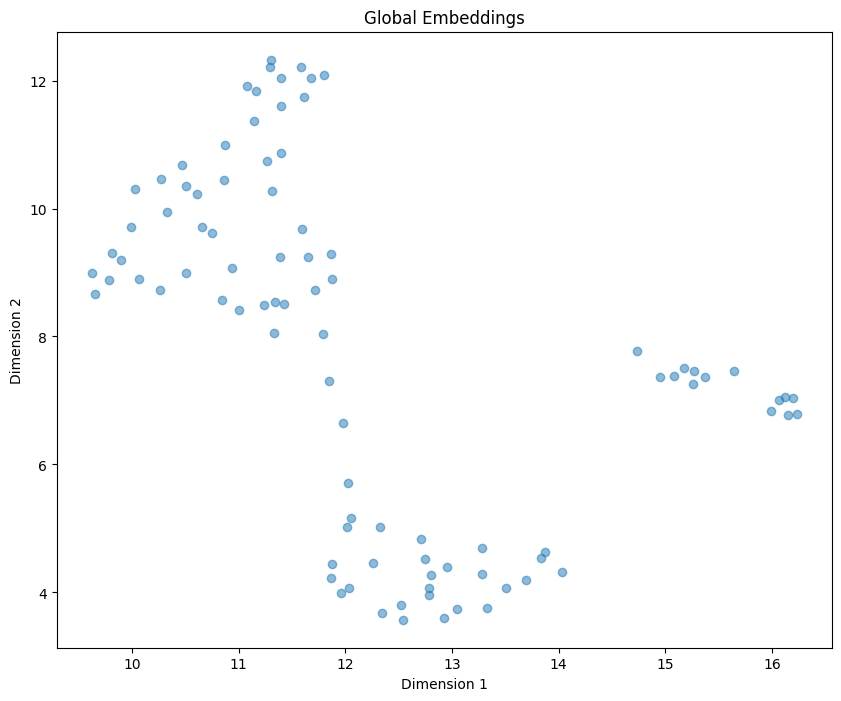

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

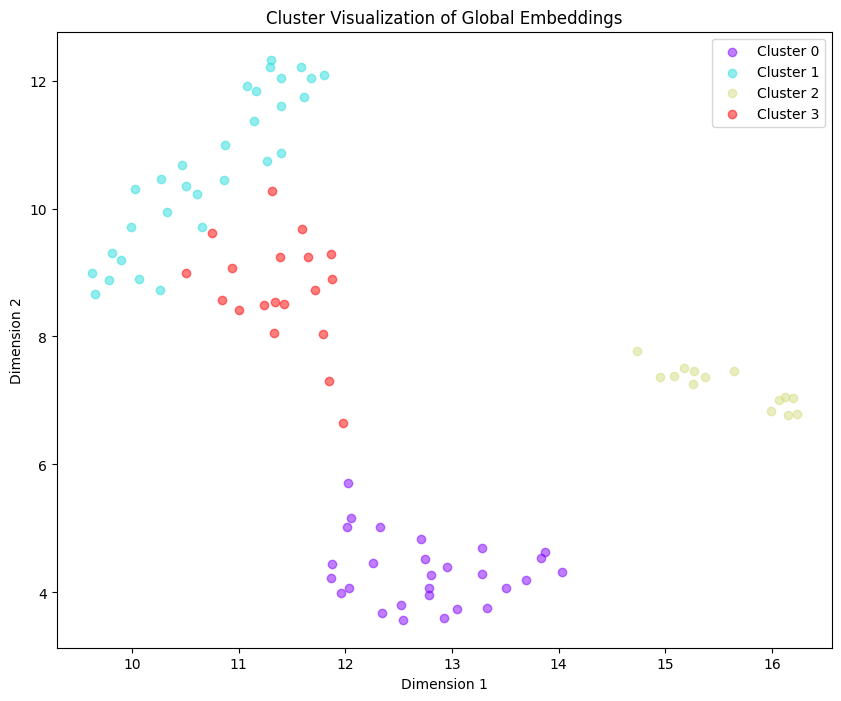

In [16]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [17]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text              Embedding  \
0  remember to have felt quite uncomfortable and ...  [13.86817, 4.6308246]   
1  basket, who, very reluctantly, produced from i...  [10.068261, 8.903872]   
2  to endeavour without any effect to prove to he...  [11.242249, 8.498863]   

   Cluster  
0        0  
1        1  
2        3  


In [18]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [19]:
clustered_texts = format_cluster_texts(df)

In [20]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [21]:
from tqdm import tqdm

In [22]:
summaries = {}
for cluster, text in tqdm(clustered_texts.items()):
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

100%|██████████| 4/4 [00:44<00:00, 11.23s/it]


In [23]:
summaries
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

In [24]:
embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [25]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    
    clustered_summaries[label].append(list(summaries.values())[i])

In [26]:
clustered_summaries

{0: ['Here is a detailed summary of the text:\n\nThe narrator recalls feeling uncomfortable and confused about an event from their past. They remember that their mother had been married to a much older man who died shortly after their marriage. The narrator\'s mother was left alone with a child on the way, and they recall her being anxious and worried.\n\nOn a particular day, their mother saw a strange lady coming up the garden path. She immediately recognized this woman as Miss Betsey, an old acquaintance of theirs. Miss Betsey was known for her stern demeanor and authoritative presence.\n\nWhen Miss Betsey entered the house, she greeted my mother with a formal "Mrs. David Copperfield," emphasizing her mourning attire and condition. My mother was overcome with emotion and cried until she had finished.\n\nMiss Betsey then sat down in a chair by the fire, frowning at it as if trying to intimidate it. She suddenly asked why their house was called Rookery, implying that it would have been

In [27]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [28]:
final_summaries

{0: 'Here is a detailed summary of the text:\n\n**Summary**\n\nThe narrator recalls an event from their past where they were uncomfortable and confused about an encounter with Miss Betsey, an old acquaintance of theirs. The scene takes place in their home, where Miss Betsey visits their mother, who is anxious and worried due to her pregnancy.\n\n**Key Points**\n\n* Miss Betsey arrives at the narrator\'s home and greets my mother with a formal "Mrs. David Copperfield," emphasizing her mourning attire.\n* Miss Betsey asks why the house is called Rookery instead of Cookery, which unsettles her and causes her to faint.\n* When Miss Betsey comes to, she stands by the window, looking out into the twilight, and my mother offers her tea, but Miss Betsey declines.\n* Miss Betsey corrects my mother\'s pronunciation of Peggotty\'s name, saying that it is actually "Peggotty" who has been the recognized authority in the house.\n\n**Character Analysis**\n\n* Miss Betsey: strict, opinionated, fiercel

In [29]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [31]:
combined_texts

['remember to have felt quite uncomfortable and confused, at a part of myself being\ndisposed of in that way. The caul was won, I recollect, by an old lady with a hand-',
 'basket, who, very reluctantly, produced from it the stipulated five shillings, all  inhalfpence, and twopence halfpenny short—as it took an immense time and a greatwaste of arithmetic, to endeavour',
 'to endeavour without any effect to prove to her. It  is  a  factwhich will be long remembered as remarkable down there, that she was  neverdrowned, but died triumphantly in bed, at ninety-two. I have',
 'ninety-two. I have understood that it was,to the last, her proudest boast, that she never had been on the water  in  her  life,except upon a bridge; and that over her tea (to which she was extremely',
 "she was extremely partial)she, to the last, expressed her indignation at the impiety of mariners  and  others,who had the presumption to go 'meandering' about the world. It was in vain torepresent to",
 'vain toreprese

## Pinecone Vetor Database

In [ ]:
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import PineconeHybridSearchRetriever

In [ ]:
pc = Pinecone(api_key='d7204d21-cb62-4544-b49c-9169b420c0e1')

In [ ]:
index_name = 'sbert-50dim'

In [ ]:
pc.create_index(name=index_name,dimension=4096,metric="dotproduct",spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"))

In [ ]:
from pinecone_text.sparse import BM25Encoder

In [33]:
bm25encoder = BM25Encoder()

In [ ]:
bm25encoder.fit(combined_texts)
index =pc.Index(index_name)

In [ ]:
retriever = PineconeHybridSearchRetriever(
    embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  8
)

In [ ]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while tqdm(final_number < max_threshold):
        retriever = PineconeHybridSearchRetriever(
                embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  final_number)
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 5
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 40)

In [ ]:
retriever = PineconeHybridSearchRetriever(
                embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  final_number)

In [ ]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")

## Building Chatbot

In [ ]:
import gradio as gr

In [ ]:
## to modify

def chatfunction(text_box,history):
    querry = text_box
    index =pc.Index(index_name)
    retriever = PineconeHybridSearchRetriever(
    embeddings= OllamaEmbeddings(model='llama3.1'), sparse_encoder=bm25encoder, index=index,top_k=  165)
    
    template = """
    Answer the question based only on the following context:
    {context}

    Answer the following question:
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)


    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model1
        | StrOutputParser())

    response_text = rag_chain.invoke(querry)

    return response_text

In [ ]:
gr.ChatInterface(fn =chatfunction, textbox= gr.Textbox(placeholder= " enter message here"),
                 chatbot= gr.Chatbot()).launch()

In [95]:
dense_dim

4096